In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [5]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in contact
    def is_contact(description):
        return 1 if description in ["foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score", 'hit_into_play'] else 0 
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df
    # Define a function to determine if the pitch resulted in a fly ball
    def is_foul(description):
        return 1 if description in ["foul_tip", "foul_pitchout", 'foul', 'foul_pitchout'] else 0

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['contact'] = df['description'].apply(is_contact)


    df['foul'] = df['description'].apply(is_foul)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [6]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('contact == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [7]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [8]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'contact',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'contact',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [9]:
train_data = training_features.drop(['foul'], axis=1).copy()
train_label = training_features['foul'].copy()
testing_data = testing_features.drop(['foul'], axis=1).copy()
testing_label = testing_features['foul'].copy()

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [12]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [13]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5660429874748725
Log Loss: 0.680160924723163


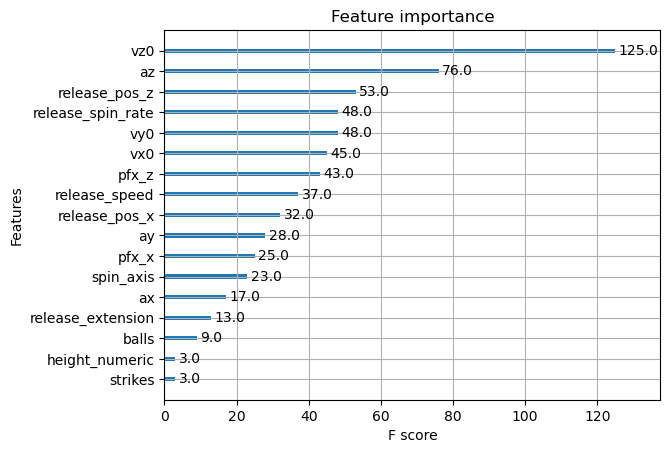

In [15]:
xgb.plot_importance(model)
plt.show()

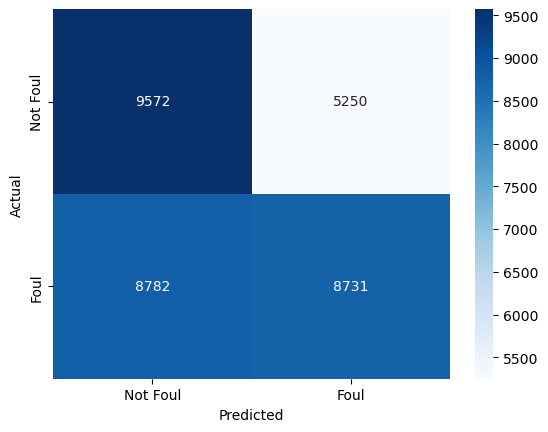

In [16]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-12 12:41:25,448] A new study created in memory with name: no-name-2d35be6b-e55a-4600-bf60-b36e1359aa0c


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68802
[2]	eval-logloss:0.68599
[3]	eval-logloss:0.68287
[4]	eval-logloss:0.68192
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67847
[7]	eval-logloss:0.67806
[8]	eval-logloss:0.67783
[9]	eval-logloss:0.67780
[10]	eval-logloss:0.67690
[11]	eval-logloss:0.67626
[12]	eval-logloss:0.67562
[13]	eval-logloss:0.67556
[14]	eval-logloss:0.67539
[15]	eval-logloss:0.67527
[16]	eval-logloss:0.67515
[17]	eval-logloss:0.67473
[18]	eval-logloss:0.67457
[19]	eval-logloss:0.67440
[20]	eval-logloss:0.67435
[21]	eval-logloss:0.67443
[22]	eval-logloss:0.67420
[23]	eval-logloss:0.67404
[24]	eval-logloss:0.67390
[25]	eval-logloss:0.67389
[26]	eval-logloss:0.67385
[27]	eval-logloss:0.67377
[28]	eval-logloss:0.67378
[29]	eval-logloss:0.67379
[30]	eval-logloss:0.67385
[31]	eval-logloss:0.67390
[32]	eval-logloss:0.67379
[33]	eval-logloss:0.67379
[34]	eval-logloss:0.67375
[35]	eval-logloss:0.67362
[36]	eval-logloss:0.67362
[37]	eval-logloss:0.67368
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:26,913] Trial 0 finished with value: 0.6752378709400643 and parameters: {'max_depth': 6, 'eta': 0.17940129047313808, 'subsample': 0.6962109921266606, 'colsample_bytree': 0.5445321809571091}. Best is trial 0 with value: 0.6752378709400643.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68790
[3]	eval-logloss:0.68646
[4]	eval-logloss:0.68521
[5]	eval-logloss:0.68406
[6]	eval-logloss:0.68300
[7]	eval-logloss:0.68214
[8]	eval-logloss:0.68132
[9]	eval-logloss:0.68059
[10]	eval-logloss:0.67992
[11]	eval-logloss:0.67934
[12]	eval-logloss:0.67877
[13]	eval-logloss:0.67827
[14]	eval-logloss:0.67777
[15]	eval-logloss:0.67746
[16]	eval-logloss:0.67713
[17]	eval-logloss:0.67676
[18]	eval-logloss:0.67634
[19]	eval-logloss:0.67601
[20]	eval-logloss:0.67574
[21]	eval-logloss:0.67559
[22]	eval-logloss:0.67543
[23]	eval-logloss:0.67517
[24]	eval-logloss:0.67491
[25]	eval-logloss:0.67487
[26]	eval-logloss:0.67467
[27]	eval-logloss:0.67449
[28]	eval-logloss:0.67445
[29]	eval-logloss:0.67427
[30]	eval-logloss:0.67419
[31]	eval-logloss:0.67403
[32]	eval-logloss:0.67395
[33]	eval-logloss:0.67376
[34]	eval-logloss:0.67368
[35]	eval-logloss:0.67362
[36]	eval-logloss:0.67353
[37]	eval-logloss:0.67347
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:28,534] Trial 1 finished with value: 0.6715631058578498 and parameters: {'max_depth': 7, 'eta': 0.06151722546133014, 'subsample': 0.8469018054509694, 'colsample_bytree': 0.8462146723103214}. Best is trial 1 with value: 0.6715631058578498.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68978
[2]	eval-logloss:0.68835
[3]	eval-logloss:0.68709
[4]	eval-logloss:0.68588
[5]	eval-logloss:0.68482
[6]	eval-logloss:0.68380
[7]	eval-logloss:0.68292
[8]	eval-logloss:0.68205
[9]	eval-logloss:0.68133
[10]	eval-logloss:0.68067
[11]	eval-logloss:0.68016
[12]	eval-logloss:0.67958
[13]	eval-logloss:0.67901
[14]	eval-logloss:0.67849
[15]	eval-logloss:0.67806
[16]	eval-logloss:0.67765
[17]	eval-logloss:0.67729
[18]	eval-logloss:0.67696
[19]	eval-logloss:0.67653
[20]	eval-logloss:0.67617
[21]	eval-logloss:0.67593
[22]	eval-logloss:0.67565
[23]	eval-logloss:0.67542
[24]	eval-logloss:0.67528
[25]	eval-logloss:0.67515
[26]	eval-logloss:0.67494
[27]	eval-logloss:0.67479
[28]	eval-logloss:0.67462
[29]	eval-logloss:0.67445
[30]	eval-logloss:0.67425
[31]	eval-logloss:0.67411
[32]	eval-logloss:0.67392
[33]	eval-logloss:0.67375
[34]	eval-logloss:0.67366
[35]	eval-logloss:0.67347
[36]	eval-logloss:0.67338
[37]	eval-logloss:0.67332
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:30,147] Trial 2 finished with value: 0.6712127911718991 and parameters: {'max_depth': 7, 'eta': 0.054636410026228745, 'subsample': 0.7449974714987189, 'colsample_bytree': 0.9023860078974588}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.68959
[1]	eval-logloss:0.68497
[2]	eval-logloss:0.68196
[3]	eval-logloss:0.67987
[4]	eval-logloss:0.67949
[5]	eval-logloss:0.67836
[6]	eval-logloss:0.67754
[7]	eval-logloss:0.67780
[8]	eval-logloss:0.67715
[9]	eval-logloss:0.67730
[10]	eval-logloss:0.67743
[11]	eval-logloss:0.67772
[12]	eval-logloss:0.67786
[13]	eval-logloss:0.67822
[14]	eval-logloss:0.67855
[15]	eval-logloss:0.67916
[16]	eval-logloss:0.67949
[17]	eval-logloss:0.67932
[18]	eval-logloss:0.67938
[19]	eval-logloss:0.67950
[20]	eval-logloss:0.67968
[21]	eval-logloss:0.68050
[22]	eval-logloss:0.68081
[23]	eval-logloss:0.68106
[24]	eval-logloss:0.68114
[25]	eval-logloss:0.68126
[26]	eval-logloss:0.68147
[27]	eval-logloss:0.68156
[28]	eval-logloss:0.68203
[29]	eval-logloss:0.68225
[30]	eval-logloss:0.68223
[31]	eval-logloss:0.68251
[32]	eval-logloss:0.68235
[33]	eval-logloss:0.68269
[34]	eval-logloss:0.68282
[35]	eval-logloss:0.68303
[36]	eval-logloss:0.68319
[37]	eval-logloss:0.68359
[38]	eval-logloss:0.68

[I 2023-11-12 12:41:31,444] Trial 3 finished with value: 0.6886827423248554 and parameters: {'max_depth': 9, 'eta': 0.21333620803730013, 'subsample': 0.6618393393175503, 'colsample_bytree': 0.6832665072148578}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68747
[3]	eval-logloss:0.68577
[4]	eval-logloss:0.68493
[5]	eval-logloss:0.68364
[6]	eval-logloss:0.68242
[7]	eval-logloss:0.68197
[8]	eval-logloss:0.68088
[9]	eval-logloss:0.68006
[10]	eval-logloss:0.67923
[11]	eval-logloss:0.67858
[12]	eval-logloss:0.67803
[13]	eval-logloss:0.67738
[14]	eval-logloss:0.67678
[15]	eval-logloss:0.67646
[16]	eval-logloss:0.67621
[17]	eval-logloss:0.67581
[18]	eval-logloss:0.67550
[19]	eval-logloss:0.67506
[20]	eval-logloss:0.67483
[21]	eval-logloss:0.67475
[22]	eval-logloss:0.67454
[23]	eval-logloss:0.67445
[24]	eval-logloss:0.67429
[25]	eval-logloss:0.67419
[26]	eval-logloss:0.67405
[27]	eval-logloss:0.67389
[28]	eval-logloss:0.67390
[29]	eval-logloss:0.67383
[30]	eval-logloss:0.67383
[31]	eval-logloss:0.67370
[32]	eval-logloss:0.67354
[33]	eval-logloss:0.67343
[34]	eval-logloss:0.67347
[35]	eval-logloss:0.67349
[36]	eval-logloss:0.67342
[37]	eval-logloss:0.67336
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:33,632] Trial 4 finished with value: 0.6726813639457984 and parameters: {'max_depth': 9, 'eta': 0.06968808941291316, 'subsample': 0.7713346801533885, 'colsample_bytree': 0.7174283582687043}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69195
[3]	eval-logloss:0.69154
[4]	eval-logloss:0.69127
[5]	eval-logloss:0.69085
[6]	eval-logloss:0.69046
[7]	eval-logloss:0.69025
[8]	eval-logloss:0.68984
[9]	eval-logloss:0.68948
[10]	eval-logloss:0.68911
[11]	eval-logloss:0.68876
[12]	eval-logloss:0.68841
[13]	eval-logloss:0.68807
[14]	eval-logloss:0.68778
[15]	eval-logloss:0.68757
[16]	eval-logloss:0.68739
[17]	eval-logloss:0.68708
[18]	eval-logloss:0.68677
[19]	eval-logloss:0.68643
[20]	eval-logloss:0.68626
[21]	eval-logloss:0.68609
[22]	eval-logloss:0.68581
[23]	eval-logloss:0.68564
[24]	eval-logloss:0.68538
[25]	eval-logloss:0.68523
[26]	eval-logloss:0.68498
[27]	eval-logloss:0.68474
[28]	eval-logloss:0.68460
[29]	eval-logloss:0.68446
[30]	eval-logloss:0.68433
[31]	eval-logloss:0.68410
[32]	eval-logloss:0.68387
[33]	eval-logloss:0.68365
[34]	eval-logloss:0.68342
[35]	eval-logloss:0.68329
[36]	eval-logloss:0.68316
[37]	eval-logloss:0.68307
[38]	eval-logloss:0.68

[I 2023-11-12 12:41:35,039] Trial 5 finished with value: 0.6768976786875398 and parameters: {'max_depth': 5, 'eta': 0.01586015516305099, 'subsample': 0.7477798531214315, 'colsample_bytree': 0.6744952164047302}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68854
[3]	eval-logloss:0.68709
[4]	eval-logloss:0.68633
[5]	eval-logloss:0.68512
[6]	eval-logloss:0.68401
[7]	eval-logloss:0.68355
[8]	eval-logloss:0.68254
[9]	eval-logloss:0.68155
[10]	eval-logloss:0.68069
[11]	eval-logloss:0.68003
[12]	eval-logloss:0.67929
[13]	eval-logloss:0.67868
[14]	eval-logloss:0.67803
[15]	eval-logloss:0.67766
[16]	eval-logloss:0.67732
[17]	eval-logloss:0.67679
[18]	eval-logloss:0.67639
[19]	eval-logloss:0.67600
[20]	eval-logloss:0.67578
[21]	eval-logloss:0.67560
[22]	eval-logloss:0.67530
[23]	eval-logloss:0.67519
[24]	eval-logloss:0.67491
[25]	eval-logloss:0.67487
[26]	eval-logloss:0.67464
[27]	eval-logloss:0.67424
[28]	eval-logloss:0.67408
[29]	eval-logloss:0.67401
[30]	eval-logloss:0.67394
[31]	eval-logloss:0.67373
[32]	eval-logloss:0.67355
[33]	eval-logloss:0.67335
[34]	eval-logloss:0.67318
[35]	eval-logloss:0.67313
[36]	eval-logloss:0.67308
[37]	eval-logloss:0.67304
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:36,996] Trial 6 finished with value: 0.6713655923151743 and parameters: {'max_depth': 8, 'eta': 0.05559782524997592, 'subsample': 0.8491706596383127, 'colsample_bytree': 0.7073459517259919}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.68930
[1]	eval-logloss:0.68364
[2]	eval-logloss:0.68132
[3]	eval-logloss:0.67864
[4]	eval-logloss:0.67803
[5]	eval-logloss:0.67638
[6]	eval-logloss:0.67552
[7]	eval-logloss:0.67551
[8]	eval-logloss:0.67528
[9]	eval-logloss:0.67532
[10]	eval-logloss:0.67499
[11]	eval-logloss:0.67468
[12]	eval-logloss:0.67445
[13]	eval-logloss:0.67440
[14]	eval-logloss:0.67447
[15]	eval-logloss:0.67448
[16]	eval-logloss:0.67435
[17]	eval-logloss:0.67418
[18]	eval-logloss:0.67416
[19]	eval-logloss:0.67400
[20]	eval-logloss:0.67385
[21]	eval-logloss:0.67400
[22]	eval-logloss:0.67414
[23]	eval-logloss:0.67411
[24]	eval-logloss:0.67398
[25]	eval-logloss:0.67410
[26]	eval-logloss:0.67437
[27]	eval-logloss:0.67444
[28]	eval-logloss:0.67459
[29]	eval-logloss:0.67464
[30]	eval-logloss:0.67466
[31]	eval-logloss:0.67477
[32]	eval-logloss:0.67462
[33]	eval-logloss:0.67468
[34]	eval-logloss:0.67474
[35]	eval-logloss:0.67480
[36]	eval-logloss:0.67493
[37]	eval-logloss:0.67485
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:38,201] Trial 7 finished with value: 0.6781051085492278 and parameters: {'max_depth': 7, 'eta': 0.2598785218210204, 'subsample': 0.8504800577783193, 'colsample_bytree': 0.5645147766508292}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68457
[3]	eval-logloss:0.68215
[4]	eval-logloss:0.68106
[5]	eval-logloss:0.67903
[6]	eval-logloss:0.67767
[7]	eval-logloss:0.67728
[8]	eval-logloss:0.67630
[9]	eval-logloss:0.67603
[10]	eval-logloss:0.67548
[11]	eval-logloss:0.67516
[12]	eval-logloss:0.67477
[13]	eval-logloss:0.67443
[14]	eval-logloss:0.67415
[15]	eval-logloss:0.67410
[16]	eval-logloss:0.67417
[17]	eval-logloss:0.67389
[18]	eval-logloss:0.67381
[19]	eval-logloss:0.67369
[20]	eval-logloss:0.67364
[21]	eval-logloss:0.67371
[22]	eval-logloss:0.67356
[23]	eval-logloss:0.67356
[24]	eval-logloss:0.67364
[25]	eval-logloss:0.67359
[26]	eval-logloss:0.67353
[27]	eval-logloss:0.67353
[28]	eval-logloss:0.67344
[29]	eval-logloss:0.67333
[30]	eval-logloss:0.67336
[31]	eval-logloss:0.67335
[32]	eval-logloss:0.67324
[33]	eval-logloss:0.67334
[34]	eval-logloss:0.67339
[35]	eval-logloss:0.67341
[36]	eval-logloss:0.67384
[37]	eval-logloss:0.67393
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:39,763] Trial 8 finished with value: 0.6768385716795112 and parameters: {'max_depth': 8, 'eta': 0.15391111131862337, 'subsample': 0.7859237117992622, 'colsample_bytree': 0.6175973571700082}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68544
[2]	eval-logloss:0.68377
[3]	eval-logloss:0.68124
[4]	eval-logloss:0.68030
[5]	eval-logloss:0.67842
[6]	eval-logloss:0.67723
[7]	eval-logloss:0.67699
[8]	eval-logloss:0.67603
[9]	eval-logloss:0.67576
[10]	eval-logloss:0.67522
[11]	eval-logloss:0.67486
[12]	eval-logloss:0.67461
[13]	eval-logloss:0.67442
[14]	eval-logloss:0.67433
[15]	eval-logloss:0.67410
[16]	eval-logloss:0.67393
[17]	eval-logloss:0.67367
[18]	eval-logloss:0.67362
[19]	eval-logloss:0.67343
[20]	eval-logloss:0.67339
[21]	eval-logloss:0.67336
[22]	eval-logloss:0.67329
[23]	eval-logloss:0.67313
[24]	eval-logloss:0.67317
[25]	eval-logloss:0.67311
[26]	eval-logloss:0.67299
[27]	eval-logloss:0.67294
[28]	eval-logloss:0.67303
[29]	eval-logloss:0.67299
[30]	eval-logloss:0.67313
[31]	eval-logloss:0.67319
[32]	eval-logloss:0.67307
[33]	eval-logloss:0.67315
[34]	eval-logloss:0.67305
[35]	eval-logloss:0.67301
[36]	eval-logloss:0.67302
[37]	eval-logloss:0.67299
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:41,132] Trial 9 finished with value: 0.6737937574395713 and parameters: {'max_depth': 5, 'eta': 0.21390267073112423, 'subsample': 0.7289744618920688, 'colsample_bytree': 0.6303807388756026}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68786
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68530
[5]	eval-logloss:0.68424
[6]	eval-logloss:0.68322
[7]	eval-logloss:0.68246
[8]	eval-logloss:0.68181
[9]	eval-logloss:0.68118
[10]	eval-logloss:0.68047
[11]	eval-logloss:0.68006
[12]	eval-logloss:0.67974
[13]	eval-logloss:0.67939
[14]	eval-logloss:0.67899
[15]	eval-logloss:0.67865
[16]	eval-logloss:0.67846
[17]	eval-logloss:0.67829
[18]	eval-logloss:0.67804
[19]	eval-logloss:0.67780
[20]	eval-logloss:0.67750
[21]	eval-logloss:0.67739
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67704
[24]	eval-logloss:0.67688
[25]	eval-logloss:0.67671
[26]	eval-logloss:0.67655
[27]	eval-logloss:0.67632
[28]	eval-logloss:0.67618
[29]	eval-logloss:0.67609
[30]	eval-logloss:0.67603
[31]	eval-logloss:0.67589
[32]	eval-logloss:0.67574
[33]	eval-logloss:0.67569
[34]	eval-logloss:0.67564
[35]	eval-logloss:0.67550
[36]	eval-logloss:0.67542
[37]	eval-logloss:0.67537
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:42,428] Trial 10 finished with value: 0.673108956817321 and parameters: {'max_depth': 3, 'eta': 0.09862478443623243, 'subsample': 0.6112187101857581, 'colsample_bytree': 0.9698573392383716}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69082
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.68949
[5]	eval-logloss:0.68882
[6]	eval-logloss:0.68820
[7]	eval-logloss:0.68767
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68653
[10]	eval-logloss:0.68600
[11]	eval-logloss:0.68551
[12]	eval-logloss:0.68503
[13]	eval-logloss:0.68456
[14]	eval-logloss:0.68415
[15]	eval-logloss:0.68386
[16]	eval-logloss:0.68348
[17]	eval-logloss:0.68305
[18]	eval-logloss:0.68268
[19]	eval-logloss:0.68229
[20]	eval-logloss:0.68193
[21]	eval-logloss:0.68173
[22]	eval-logloss:0.68142
[23]	eval-logloss:0.68111
[24]	eval-logloss:0.68081
[25]	eval-logloss:0.68063
[26]	eval-logloss:0.68037
[27]	eval-logloss:0.68011
[28]	eval-logloss:0.67994
[29]	eval-logloss:0.67968
[30]	eval-logloss:0.67954
[31]	eval-logloss:0.67930
[32]	eval-logloss:0.67906
[33]	eval-logloss:0.67883
[34]	eval-logloss:0.67862
[35]	eval-logloss:0.67843
[36]	eval-logloss:0.67827
[37]	eval-logloss:0.67808
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:44,539] Trial 11 finished with value: 0.6729690113806587 and parameters: {'max_depth': 7, 'eta': 0.02388634737591486, 'subsample': 0.8990612752450846, 'colsample_bytree': 0.8004802438914053}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.68694
[2]	eval-logloss:0.68438
[3]	eval-logloss:0.68250
[4]	eval-logloss:0.68104
[5]	eval-logloss:0.67970
[6]	eval-logloss:0.67850
[7]	eval-logloss:0.67778
[8]	eval-logloss:0.67697
[9]	eval-logloss:0.67639
[10]	eval-logloss:0.67584
[11]	eval-logloss:0.67554
[12]	eval-logloss:0.67503
[13]	eval-logloss:0.67465
[14]	eval-logloss:0.67431
[15]	eval-logloss:0.67411
[16]	eval-logloss:0.67394
[17]	eval-logloss:0.67373
[18]	eval-logloss:0.67363
[19]	eval-logloss:0.67334
[20]	eval-logloss:0.67329
[21]	eval-logloss:0.67340
[22]	eval-logloss:0.67332
[23]	eval-logloss:0.67326
[24]	eval-logloss:0.67305
[25]	eval-logloss:0.67296
[26]	eval-logloss:0.67288
[27]	eval-logloss:0.67287
[28]	eval-logloss:0.67284
[29]	eval-logloss:0.67284
[30]	eval-logloss:0.67274
[31]	eval-logloss:0.67276
[32]	eval-logloss:0.67289
[33]	eval-logloss:0.67286
[34]	eval-logloss:0.67294
[35]	eval-logloss:0.67285
[36]	eval-logloss:0.67288
[37]	eval-logloss:0.67294
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:46,588] Trial 12 finished with value: 0.6740861079086882 and parameters: {'max_depth': 8, 'eta': 0.11011273949245381, 'subsample': 0.8059687994857008, 'colsample_bytree': 0.845689266762995}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68943
[2]	eval-logloss:0.68774
[3]	eval-logloss:0.68639
[4]	eval-logloss:0.68521
[5]	eval-logloss:0.68403
[6]	eval-logloss:0.68296
[7]	eval-logloss:0.68218
[8]	eval-logloss:0.68127
[9]	eval-logloss:0.68055
[10]	eval-logloss:0.67982
[11]	eval-logloss:0.67927
[12]	eval-logloss:0.67877
[13]	eval-logloss:0.67817
[14]	eval-logloss:0.67763
[15]	eval-logloss:0.67730
[16]	eval-logloss:0.67697
[17]	eval-logloss:0.67656
[18]	eval-logloss:0.67618
[19]	eval-logloss:0.67575
[20]	eval-logloss:0.67547
[21]	eval-logloss:0.67535
[22]	eval-logloss:0.67507
[23]	eval-logloss:0.67481
[24]	eval-logloss:0.67457
[25]	eval-logloss:0.67446
[26]	eval-logloss:0.67427
[27]	eval-logloss:0.67408
[28]	eval-logloss:0.67395
[29]	eval-logloss:0.67384
[30]	eval-logloss:0.67377
[31]	eval-logloss:0.67363
[32]	eval-logloss:0.67348
[33]	eval-logloss:0.67339
[34]	eval-logloss:0.67332
[35]	eval-logloss:0.67318
[36]	eval-logloss:0.67313
[37]	eval-logloss:0.67307
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:49,745] Trial 13 finished with value: 0.6716081288521619 and parameters: {'max_depth': 8, 'eta': 0.05677974548234453, 'subsample': 0.7270729242880226, 'colsample_bytree': 0.7617583823441599}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69218
[3]	eval-logloss:0.69187
[4]	eval-logloss:0.69157
[5]	eval-logloss:0.69127
[6]	eval-logloss:0.69097
[7]	eval-logloss:0.69068
[8]	eval-logloss:0.69039
[9]	eval-logloss:0.69011
[10]	eval-logloss:0.68983
[11]	eval-logloss:0.68958
[12]	eval-logloss:0.68931
[13]	eval-logloss:0.68906
[14]	eval-logloss:0.68880
[15]	eval-logloss:0.68854
[16]	eval-logloss:0.68832
[17]	eval-logloss:0.68807
[18]	eval-logloss:0.68784
[19]	eval-logloss:0.68760
[20]	eval-logloss:0.68736
[21]	eval-logloss:0.68715
[22]	eval-logloss:0.68693
[23]	eval-logloss:0.68670
[24]	eval-logloss:0.68649
[25]	eval-logloss:0.68631
[26]	eval-logloss:0.68611
[27]	eval-logloss:0.68591
[28]	eval-logloss:0.68570
[29]	eval-logloss:0.68550
[30]	eval-logloss:0.68531
[31]	eval-logloss:0.68512
[32]	eval-logloss:0.68493
[33]	eval-logloss:0.68475
[34]	eval-logloss:0.68456
[35]	eval-logloss:0.68439
[36]	eval-logloss:0.68421
[37]	eval-logloss:0.68404
[38]	eval-logloss:0.68

[I 2023-11-12 12:41:52,587] Trial 14 finished with value: 0.6776410657827879 and parameters: {'max_depth': 6, 'eta': 0.010263990128160268, 'subsample': 0.8068285200287466, 'colsample_bytree': 0.963142257676878}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68791
[2]	eval-logloss:0.68593
[3]	eval-logloss:0.68435
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68185
[6]	eval-logloss:0.68084
[7]	eval-logloss:0.68014
[8]	eval-logloss:0.67935
[9]	eval-logloss:0.67864
[10]	eval-logloss:0.67806
[11]	eval-logloss:0.67772
[12]	eval-logloss:0.67731
[13]	eval-logloss:0.67705
[14]	eval-logloss:0.67671
[15]	eval-logloss:0.67640
[16]	eval-logloss:0.67624
[17]	eval-logloss:0.67600
[18]	eval-logloss:0.67578
[19]	eval-logloss:0.67558
[20]	eval-logloss:0.67536
[21]	eval-logloss:0.67522
[22]	eval-logloss:0.67501
[23]	eval-logloss:0.67488
[24]	eval-logloss:0.67477
[25]	eval-logloss:0.67471
[26]	eval-logloss:0.67461
[27]	eval-logloss:0.67444
[28]	eval-logloss:0.67435
[29]	eval-logloss:0.67427
[30]	eval-logloss:0.67420
[31]	eval-logloss:0.67412
[32]	eval-logloss:0.67397
[33]	eval-logloss:0.67392
[34]	eval-logloss:0.67382
[35]	eval-logloss:0.67372
[36]	eval-logloss:0.67362
[37]	eval-logloss:0.67357
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:54,591] Trial 15 finished with value: 0.6721789704963417 and parameters: {'max_depth': 4, 'eta': 0.11903938316996734, 'subsample': 0.7638379067380785, 'colsample_bytree': 0.8937988028390244}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68802
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68409
[4]	eval-logloss:0.68280
[5]	eval-logloss:0.68135
[6]	eval-logloss:0.68023
[7]	eval-logloss:0.67947
[8]	eval-logloss:0.67854
[9]	eval-logloss:0.67783
[10]	eval-logloss:0.67712
[11]	eval-logloss:0.67672
[12]	eval-logloss:0.67622
[13]	eval-logloss:0.67584
[14]	eval-logloss:0.67531
[15]	eval-logloss:0.67508
[16]	eval-logloss:0.67485
[17]	eval-logloss:0.67458
[18]	eval-logloss:0.67435
[19]	eval-logloss:0.67395
[20]	eval-logloss:0.67373
[21]	eval-logloss:0.67369
[22]	eval-logloss:0.67351
[23]	eval-logloss:0.67341
[24]	eval-logloss:0.67321
[25]	eval-logloss:0.67308
[26]	eval-logloss:0.67307
[27]	eval-logloss:0.67299
[28]	eval-logloss:0.67283
[29]	eval-logloss:0.67276
[30]	eval-logloss:0.67276
[31]	eval-logloss:0.67266
[32]	eval-logloss:0.67266
[33]	eval-logloss:0.67265
[34]	eval-logloss:0.67264
[35]	eval-logloss:0.67262
[36]	eval-logloss:0.67252
[37]	eval-logloss:0.67252
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:58,645] Trial 16 finished with value: 0.6725664640108961 and parameters: {'max_depth': 8, 'eta': 0.08239491694293753, 'subsample': 0.6882837238903428, 'colsample_bytree': 0.7582714844492063}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68848
[4]	eval-logloss:0.68758
[5]	eval-logloss:0.68665
[6]	eval-logloss:0.68577
[7]	eval-logloss:0.68498
[8]	eval-logloss:0.68423
[9]	eval-logloss:0.68354
[10]	eval-logloss:0.68289
[11]	eval-logloss:0.68233
[12]	eval-logloss:0.68174
[13]	eval-logloss:0.68118
[14]	eval-logloss:0.68068
[15]	eval-logloss:0.68024
[16]	eval-logloss:0.67977
[17]	eval-logloss:0.67931
[18]	eval-logloss:0.67896
[19]	eval-logloss:0.67859
[20]	eval-logloss:0.67824
[21]	eval-logloss:0.67799
[22]	eval-logloss:0.67769
[23]	eval-logloss:0.67736
[24]	eval-logloss:0.67710
[25]	eval-logloss:0.67687
[26]	eval-logloss:0.67663
[27]	eval-logloss:0.67637
[28]	eval-logloss:0.67614
[29]	eval-logloss:0.67586
[30]	eval-logloss:0.67571
[31]	eval-logloss:0.67552
[32]	eval-logloss:0.67530
[33]	eval-logloss:0.67508
[34]	eval-logloss:0.67492
[35]	eval-logloss:0.67473
[36]	eval-logloss:0.67462
[37]	eval-logloss:0.67451
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:02,250] Trial 17 finished with value: 0.6714516124723774 and parameters: {'max_depth': 7, 'eta': 0.039690818533131014, 'subsample': 0.8411108414059403, 'colsample_bytree': 0.9106851431034008}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68741
[4]	eval-logloss:0.68638
[5]	eval-logloss:0.68535
[6]	eval-logloss:0.68430
[7]	eval-logloss:0.68344
[8]	eval-logloss:0.68262
[9]	eval-logloss:0.68182
[10]	eval-logloss:0.68106
[11]	eval-logloss:0.68050
[12]	eval-logloss:0.67983
[13]	eval-logloss:0.67930
[14]	eval-logloss:0.67877
[15]	eval-logloss:0.67846
[16]	eval-logloss:0.67795
[17]	eval-logloss:0.67752
[18]	eval-logloss:0.67708
[19]	eval-logloss:0.67668
[20]	eval-logloss:0.67636
[21]	eval-logloss:0.67610
[22]	eval-logloss:0.67581
[23]	eval-logloss:0.67551
[24]	eval-logloss:0.67519
[25]	eval-logloss:0.67506
[26]	eval-logloss:0.67486
[27]	eval-logloss:0.67468
[28]	eval-logloss:0.67460
[29]	eval-logloss:0.67427
[30]	eval-logloss:0.67416
[31]	eval-logloss:0.67399
[32]	eval-logloss:0.67388
[33]	eval-logloss:0.67367
[34]	eval-logloss:0.67353
[35]	eval-logloss:0.67350
[36]	eval-logloss:0.67336
[37]	eval-logloss:0.67330
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:06,601] Trial 18 finished with value: 0.6715339438918968 and parameters: {'max_depth': 9, 'eta': 0.0455464825453311, 'subsample': 0.8868246525008936, 'colsample_bytree': 0.8028838675241484}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68693
[2]	eval-logloss:0.68473
[3]	eval-logloss:0.68287
[4]	eval-logloss:0.68154
[5]	eval-logloss:0.68035
[6]	eval-logloss:0.67942
[7]	eval-logloss:0.67872
[8]	eval-logloss:0.67792
[9]	eval-logloss:0.67730
[10]	eval-logloss:0.67675
[11]	eval-logloss:0.67637
[12]	eval-logloss:0.67587
[13]	eval-logloss:0.67559
[14]	eval-logloss:0.67534
[15]	eval-logloss:0.67508
[16]	eval-logloss:0.67494
[17]	eval-logloss:0.67479
[18]	eval-logloss:0.67465
[19]	eval-logloss:0.67439
[20]	eval-logloss:0.67411
[21]	eval-logloss:0.67404
[22]	eval-logloss:0.67389
[23]	eval-logloss:0.67377
[24]	eval-logloss:0.67371
[25]	eval-logloss:0.67368
[26]	eval-logloss:0.67357
[27]	eval-logloss:0.67341
[28]	eval-logloss:0.67336
[29]	eval-logloss:0.67324
[30]	eval-logloss:0.67319
[31]	eval-logloss:0.67312
[32]	eval-logloss:0.67309
[33]	eval-logloss:0.67308
[34]	eval-logloss:0.67301
[35]	eval-logloss:0.67287
[36]	eval-logloss:0.67279
[37]	eval-logloss:0.67277
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:08,950] Trial 19 finished with value: 0.6714083769288758 and parameters: {'max_depth': 5, 'eta': 0.12521343577009647, 'subsample': 0.8055753732620227, 'colsample_bytree': 0.9949715433003405}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.69177
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68927
[3]	eval-logloss:0.68737
[4]	eval-logloss:0.68658
[5]	eval-logloss:0.68489
[6]	eval-logloss:0.68357
[7]	eval-logloss:0.68306
[8]	eval-logloss:0.68273
[9]	eval-logloss:0.68247
[10]	eval-logloss:0.68152
[11]	eval-logloss:0.68056
[12]	eval-logloss:0.67969
[13]	eval-logloss:0.67935
[14]	eval-logloss:0.67898
[15]	eval-logloss:0.67862
[16]	eval-logloss:0.67828
[17]	eval-logloss:0.67767
[18]	eval-logloss:0.67714
[19]	eval-logloss:0.67659
[20]	eval-logloss:0.67639
[21]	eval-logloss:0.67621
[22]	eval-logloss:0.67586
[23]	eval-logloss:0.67572
[24]	eval-logloss:0.67544
[25]	eval-logloss:0.67534
[26]	eval-logloss:0.67508
[27]	eval-logloss:0.67486
[28]	eval-logloss:0.67482
[29]	eval-logloss:0.67481
[30]	eval-logloss:0.67477
[31]	eval-logloss:0.67461
[32]	eval-logloss:0.67436
[33]	eval-logloss:0.67432
[34]	eval-logloss:0.67409
[35]	eval-logloss:0.67408
[36]	eval-logloss:0.67402
[37]	eval-logloss:0.67396
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:11,679] Trial 20 finished with value: 0.6722619366282856 and parameters: {'max_depth': 6, 'eta': 0.0825132357486682, 'subsample': 0.7426680383354556, 'colsample_bytree': 0.50214036389938}. Best is trial 2 with value: 0.6712127911718991.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68641
[2]	eval-logloss:0.68407
[3]	eval-logloss:0.68222
[4]	eval-logloss:0.68083
[5]	eval-logloss:0.67963
[6]	eval-logloss:0.67875
[7]	eval-logloss:0.67808
[8]	eval-logloss:0.67748
[9]	eval-logloss:0.67691
[10]	eval-logloss:0.67649
[11]	eval-logloss:0.67622
[12]	eval-logloss:0.67567
[13]	eval-logloss:0.67531
[14]	eval-logloss:0.67503
[15]	eval-logloss:0.67479
[16]	eval-logloss:0.67448
[17]	eval-logloss:0.67431
[18]	eval-logloss:0.67428
[19]	eval-logloss:0.67404
[20]	eval-logloss:0.67384
[21]	eval-logloss:0.67376
[22]	eval-logloss:0.67367
[23]	eval-logloss:0.67351
[24]	eval-logloss:0.67344
[25]	eval-logloss:0.67334
[26]	eval-logloss:0.67322
[27]	eval-logloss:0.67308
[28]	eval-logloss:0.67308
[29]	eval-logloss:0.67297
[30]	eval-logloss:0.67286
[31]	eval-logloss:0.67271
[32]	eval-logloss:0.67263
[33]	eval-logloss:0.67270
[34]	eval-logloss:0.67269
[35]	eval-logloss:0.67252
[36]	eval-logloss:0.67237
[37]	eval-logloss:0.67236
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:14,506] Trial 21 finished with value: 0.6710527471918611 and parameters: {'max_depth': 5, 'eta': 0.13888097713152753, 'subsample': 0.8088888500526824, 'colsample_bytree': 0.9941784617884784}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68719
[2]	eval-logloss:0.68504
[3]	eval-logloss:0.68350
[4]	eval-logloss:0.68209
[5]	eval-logloss:0.68091
[6]	eval-logloss:0.67998
[7]	eval-logloss:0.67925
[8]	eval-logloss:0.67860
[9]	eval-logloss:0.67806
[10]	eval-logloss:0.67755
[11]	eval-logloss:0.67726
[12]	eval-logloss:0.67678
[13]	eval-logloss:0.67655
[14]	eval-logloss:0.67631
[15]	eval-logloss:0.67604
[16]	eval-logloss:0.67595
[17]	eval-logloss:0.67575
[18]	eval-logloss:0.67558
[19]	eval-logloss:0.67534
[20]	eval-logloss:0.67505
[21]	eval-logloss:0.67487
[22]	eval-logloss:0.67472
[23]	eval-logloss:0.67462
[24]	eval-logloss:0.67448
[25]	eval-logloss:0.67437
[26]	eval-logloss:0.67433
[27]	eval-logloss:0.67424
[28]	eval-logloss:0.67419
[29]	eval-logloss:0.67412
[30]	eval-logloss:0.67407
[31]	eval-logloss:0.67399
[32]	eval-logloss:0.67391
[33]	eval-logloss:0.67387
[34]	eval-logloss:0.67383
[35]	eval-logloss:0.67365
[36]	eval-logloss:0.67357
[37]	eval-logloss:0.67346
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:16,948] Trial 22 finished with value: 0.6719448169961724 and parameters: {'max_depth': 4, 'eta': 0.13759262504645708, 'subsample': 0.8271718132791511, 'colsample_bytree': 0.9472139212037533}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68869
[2]	eval-logloss:0.68692
[3]	eval-logloss:0.68536
[4]	eval-logloss:0.68410
[5]	eval-logloss:0.68294
[6]	eval-logloss:0.68201
[7]	eval-logloss:0.68121
[8]	eval-logloss:0.68044
[9]	eval-logloss:0.67972
[10]	eval-logloss:0.67910
[11]	eval-logloss:0.67868
[12]	eval-logloss:0.67818
[13]	eval-logloss:0.67778
[14]	eval-logloss:0.67743
[15]	eval-logloss:0.67713
[16]	eval-logloss:0.67695
[17]	eval-logloss:0.67679
[18]	eval-logloss:0.67655
[19]	eval-logloss:0.67632
[20]	eval-logloss:0.67612
[21]	eval-logloss:0.67604
[22]	eval-logloss:0.67582
[23]	eval-logloss:0.67565
[24]	eval-logloss:0.67554
[25]	eval-logloss:0.67544
[26]	eval-logloss:0.67536
[27]	eval-logloss:0.67519
[28]	eval-logloss:0.67508
[29]	eval-logloss:0.67501
[30]	eval-logloss:0.67485
[31]	eval-logloss:0.67476
[32]	eval-logloss:0.67461
[33]	eval-logloss:0.67458
[34]	eval-logloss:0.67452
[35]	eval-logloss:0.67443
[36]	eval-logloss:0.67437
[37]	eval-logloss:0.67430
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:18,916] Trial 23 finished with value: 0.6720542444875197 and parameters: {'max_depth': 4, 'eta': 0.09797973590765553, 'subsample': 0.7890577621304399, 'colsample_bytree': 0.9951857750978981}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69087
[2]	eval-logloss:0.68980
[3]	eval-logloss:0.68886
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68707
[6]	eval-logloss:0.68625
[7]	eval-logloss:0.68549
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68413
[10]	eval-logloss:0.68346
[11]	eval-logloss:0.68290
[12]	eval-logloss:0.68233
[13]	eval-logloss:0.68176
[14]	eval-logloss:0.68128
[15]	eval-logloss:0.68081
[16]	eval-logloss:0.68038
[17]	eval-logloss:0.67993
[18]	eval-logloss:0.67954
[19]	eval-logloss:0.67919
[20]	eval-logloss:0.67884
[21]	eval-logloss:0.67853
[22]	eval-logloss:0.67825
[23]	eval-logloss:0.67795
[24]	eval-logloss:0.67763
[25]	eval-logloss:0.67738
[26]	eval-logloss:0.67718
[27]	eval-logloss:0.67689
[28]	eval-logloss:0.67665
[29]	eval-logloss:0.67637
[30]	eval-logloss:0.67616
[31]	eval-logloss:0.67599
[32]	eval-logloss:0.67579
[33]	eval-logloss:0.67560
[34]	eval-logloss:0.67544
[35]	eval-logloss:0.67525
[36]	eval-logloss:0.67511
[37]	eval-logloss:0.67494
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:22,200] Trial 24 finished with value: 0.6718505106073952 and parameters: {'max_depth': 7, 'eta': 0.03609092588374084, 'subsample': 0.8695116760585229, 'colsample_bytree': 0.9186551442454609}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68786
[3]	eval-logloss:0.68652
[4]	eval-logloss:0.68525
[5]	eval-logloss:0.68416
[6]	eval-logloss:0.68314
[7]	eval-logloss:0.68230
[8]	eval-logloss:0.68142
[9]	eval-logloss:0.68079
[10]	eval-logloss:0.68011
[11]	eval-logloss:0.67957
[12]	eval-logloss:0.67897
[13]	eval-logloss:0.67849
[14]	eval-logloss:0.67804
[15]	eval-logloss:0.67774
[16]	eval-logloss:0.67736
[17]	eval-logloss:0.67703
[18]	eval-logloss:0.67673
[19]	eval-logloss:0.67637
[20]	eval-logloss:0.67611
[21]	eval-logloss:0.67605
[22]	eval-logloss:0.67584
[23]	eval-logloss:0.67563
[24]	eval-logloss:0.67544
[25]	eval-logloss:0.67536
[26]	eval-logloss:0.67525
[27]	eval-logloss:0.67513
[28]	eval-logloss:0.67505
[29]	eval-logloss:0.67497
[30]	eval-logloss:0.67483
[31]	eval-logloss:0.67470
[32]	eval-logloss:0.67458
[33]	eval-logloss:0.67447
[34]	eval-logloss:0.67436
[35]	eval-logloss:0.67421
[36]	eval-logloss:0.67410
[37]	eval-logloss:0.67392
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:24,576] Trial 25 finished with value: 0.6719327164164761 and parameters: {'max_depth': 5, 'eta': 0.07204892474072053, 'subsample': 0.8266880787399133, 'colsample_bytree': 0.8770350464092963}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68781
[2]	eval-logloss:0.68578
[3]	eval-logloss:0.68418
[4]	eval-logloss:0.68279
[5]	eval-logloss:0.68155
[6]	eval-logloss:0.68046
[7]	eval-logloss:0.67964
[8]	eval-logloss:0.67882
[9]	eval-logloss:0.67811
[10]	eval-logloss:0.67748
[11]	eval-logloss:0.67706
[12]	eval-logloss:0.67669
[13]	eval-logloss:0.67619
[14]	eval-logloss:0.67586
[15]	eval-logloss:0.67561
[16]	eval-logloss:0.67534
[17]	eval-logloss:0.67517
[18]	eval-logloss:0.67493
[19]	eval-logloss:0.67469
[20]	eval-logloss:0.67439
[21]	eval-logloss:0.67426
[22]	eval-logloss:0.67412
[23]	eval-logloss:0.67391
[24]	eval-logloss:0.67375
[25]	eval-logloss:0.67370
[26]	eval-logloss:0.67356
[27]	eval-logloss:0.67346
[28]	eval-logloss:0.67336
[29]	eval-logloss:0.67333
[30]	eval-logloss:0.67323
[31]	eval-logloss:0.67314
[32]	eval-logloss:0.67313
[33]	eval-logloss:0.67305
[34]	eval-logloss:0.67300
[35]	eval-logloss:0.67295
[36]	eval-logloss:0.67287
[37]	eval-logloss:0.67287
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:27,130] Trial 26 finished with value: 0.6722859732928851 and parameters: {'max_depth': 6, 'eta': 0.0966710987363254, 'subsample': 0.870097558731275, 'colsample_bytree': 0.921861147643019}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68981
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68717
[4]	eval-logloss:0.68598
[5]	eval-logloss:0.68492
[6]	eval-logloss:0.68391
[7]	eval-logloss:0.68310
[8]	eval-logloss:0.68227
[9]	eval-logloss:0.68151
[10]	eval-logloss:0.68075
[11]	eval-logloss:0.68014
[12]	eval-logloss:0.67958
[13]	eval-logloss:0.67905
[14]	eval-logloss:0.67852
[15]	eval-logloss:0.67810
[16]	eval-logloss:0.67776
[17]	eval-logloss:0.67738
[18]	eval-logloss:0.67694
[19]	eval-logloss:0.67654
[20]	eval-logloss:0.67624
[21]	eval-logloss:0.67599
[22]	eval-logloss:0.67571
[23]	eval-logloss:0.67547
[24]	eval-logloss:0.67528
[25]	eval-logloss:0.67510
[26]	eval-logloss:0.67490
[27]	eval-logloss:0.67463
[28]	eval-logloss:0.67439
[29]	eval-logloss:0.67421
[30]	eval-logloss:0.67412
[31]	eval-logloss:0.67394
[32]	eval-logloss:0.67379
[33]	eval-logloss:0.67365
[34]	eval-logloss:0.67357
[35]	eval-logloss:0.67347
[36]	eval-logloss:0.67342
[37]	eval-logloss:0.67329
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:31,608] Trial 27 finished with value: 0.671694557417427 and parameters: {'max_depth': 8, 'eta': 0.050960438593186996, 'subsample': 0.7693324316728172, 'colsample_bytree': 0.9415098348283534}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68809
[2]	eval-logloss:0.68646
[3]	eval-logloss:0.68492
[4]	eval-logloss:0.68363
[5]	eval-logloss:0.68249
[6]	eval-logloss:0.68150
[7]	eval-logloss:0.68075
[8]	eval-logloss:0.68009
[9]	eval-logloss:0.67960
[10]	eval-logloss:0.67906
[11]	eval-logloss:0.67879
[12]	eval-logloss:0.67837
[13]	eval-logloss:0.67808
[14]	eval-logloss:0.67777
[15]	eval-logloss:0.67749
[16]	eval-logloss:0.67729
[17]	eval-logloss:0.67714
[18]	eval-logloss:0.67691
[19]	eval-logloss:0.67658
[20]	eval-logloss:0.67641
[21]	eval-logloss:0.67630
[22]	eval-logloss:0.67610
[23]	eval-logloss:0.67600
[24]	eval-logloss:0.67583
[25]	eval-logloss:0.67574
[26]	eval-logloss:0.67566
[27]	eval-logloss:0.67542
[28]	eval-logloss:0.67526
[29]	eval-logloss:0.67518
[30]	eval-logloss:0.67505
[31]	eval-logloss:0.67499
[32]	eval-logloss:0.67487
[33]	eval-logloss:0.67486
[34]	eval-logloss:0.67479
[35]	eval-logloss:0.67471
[36]	eval-logloss:0.67462
[37]	eval-logloss:0.67450
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:33,542] Trial 28 finished with value: 0.6724309611882804 and parameters: {'max_depth': 3, 'eta': 0.1355167463158103, 'subsample': 0.8196912912811386, 'colsample_bytree': 0.9967735124023529}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.68823
[1]	eval-logloss:0.68452
[2]	eval-logloss:0.68193
[3]	eval-logloss:0.68014
[4]	eval-logloss:0.67856
[5]	eval-logloss:0.67734
[6]	eval-logloss:0.67637
[7]	eval-logloss:0.67578
[8]	eval-logloss:0.67508
[9]	eval-logloss:0.67463
[10]	eval-logloss:0.67413
[11]	eval-logloss:0.67394
[12]	eval-logloss:0.67371
[13]	eval-logloss:0.67347
[14]	eval-logloss:0.67329
[15]	eval-logloss:0.67301
[16]	eval-logloss:0.67291
[17]	eval-logloss:0.67278
[18]	eval-logloss:0.67269
[19]	eval-logloss:0.67244
[20]	eval-logloss:0.67241
[21]	eval-logloss:0.67238
[22]	eval-logloss:0.67220
[23]	eval-logloss:0.67206
[24]	eval-logloss:0.67204
[25]	eval-logloss:0.67212
[26]	eval-logloss:0.67199
[27]	eval-logloss:0.67190
[28]	eval-logloss:0.67197
[29]	eval-logloss:0.67197
[30]	eval-logloss:0.67199
[31]	eval-logloss:0.67199
[32]	eval-logloss:0.67188
[33]	eval-logloss:0.67188
[34]	eval-logloss:0.67193
[35]	eval-logloss:0.67187
[36]	eval-logloss:0.67179
[37]	eval-logloss:0.67165
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:35,835] Trial 29 finished with value: 0.672119877832118 and parameters: {'max_depth': 6, 'eta': 0.179370949604912, 'subsample': 0.7892261347832813, 'colsample_bytree': 0.8832422871352782}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69107
[2]	eval-logloss:0.69013
[3]	eval-logloss:0.68919
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68759
[6]	eval-logloss:0.68682
[7]	eval-logloss:0.68611
[8]	eval-logloss:0.68542
[9]	eval-logloss:0.68481
[10]	eval-logloss:0.68418
[11]	eval-logloss:0.68362
[12]	eval-logloss:0.68309
[13]	eval-logloss:0.68258
[14]	eval-logloss:0.68214
[15]	eval-logloss:0.68168
[16]	eval-logloss:0.68124
[17]	eval-logloss:0.68081
[18]	eval-logloss:0.68043
[19]	eval-logloss:0.68007
[20]	eval-logloss:0.67970
[21]	eval-logloss:0.67938
[22]	eval-logloss:0.67909
[23]	eval-logloss:0.67879
[24]	eval-logloss:0.67851
[25]	eval-logloss:0.67824
[26]	eval-logloss:0.67800
[27]	eval-logloss:0.67777
[28]	eval-logloss:0.67753
[29]	eval-logloss:0.67723
[30]	eval-logloss:0.67704
[31]	eval-logloss:0.67685
[32]	eval-logloss:0.67665
[33]	eval-logloss:0.67639
[34]	eval-logloss:0.67619
[35]	eval-logloss:0.67602
[36]	eval-logloss:0.67590
[37]	eval-logloss:0.67574
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:38,964] Trial 30 finished with value: 0.672048593923022 and parameters: {'max_depth': 7, 'eta': 0.03226261141458103, 'subsample': 0.8614901862393693, 'colsample_bytree': 0.9534860003057937}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68689
[2]	eval-logloss:0.68477
[3]	eval-logloss:0.68300
[4]	eval-logloss:0.68154
[5]	eval-logloss:0.68033
[6]	eval-logloss:0.67941
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67782
[9]	eval-logloss:0.67714
[10]	eval-logloss:0.67665
[11]	eval-logloss:0.67624
[12]	eval-logloss:0.67574
[13]	eval-logloss:0.67543
[14]	eval-logloss:0.67514
[15]	eval-logloss:0.67486
[16]	eval-logloss:0.67470
[17]	eval-logloss:0.67454
[18]	eval-logloss:0.67439
[19]	eval-logloss:0.67418
[20]	eval-logloss:0.67392
[21]	eval-logloss:0.67385
[22]	eval-logloss:0.67371
[23]	eval-logloss:0.67360
[24]	eval-logloss:0.67355
[25]	eval-logloss:0.67345
[26]	eval-logloss:0.67340
[27]	eval-logloss:0.67322
[28]	eval-logloss:0.67318
[29]	eval-logloss:0.67311
[30]	eval-logloss:0.67304
[31]	eval-logloss:0.67300
[32]	eval-logloss:0.67290
[33]	eval-logloss:0.67292
[34]	eval-logloss:0.67288
[35]	eval-logloss:0.67273
[36]	eval-logloss:0.67269
[37]	eval-logloss:0.67259
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:41,127] Trial 31 finished with value: 0.6714539405678448 and parameters: {'max_depth': 5, 'eta': 0.12684492369793135, 'subsample': 0.808622948230473, 'colsample_bytree': 0.9884599116683535}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68803
[3]	eval-logloss:0.68673
[4]	eval-logloss:0.68554
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68352
[7]	eval-logloss:0.68271
[8]	eval-logloss:0.68190
[9]	eval-logloss:0.68116
[10]	eval-logloss:0.68052
[11]	eval-logloss:0.67992
[12]	eval-logloss:0.67942
[13]	eval-logloss:0.67898
[14]	eval-logloss:0.67856
[15]	eval-logloss:0.67818
[16]	eval-logloss:0.67780
[17]	eval-logloss:0.67745
[18]	eval-logloss:0.67715
[19]	eval-logloss:0.67683
[20]	eval-logloss:0.67649
[21]	eval-logloss:0.67630
[22]	eval-logloss:0.67608
[23]	eval-logloss:0.67585
[24]	eval-logloss:0.67566
[25]	eval-logloss:0.67559
[26]	eval-logloss:0.67548
[27]	eval-logloss:0.67526
[28]	eval-logloss:0.67512
[29]	eval-logloss:0.67495
[30]	eval-logloss:0.67483
[31]	eval-logloss:0.67464
[32]	eval-logloss:0.67453
[33]	eval-logloss:0.67441
[34]	eval-logloss:0.67433
[35]	eval-logloss:0.67423
[36]	eval-logloss:0.67411
[37]	eval-logloss:0.67397
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:43,264] Trial 32 finished with value: 0.6717777271064763 and parameters: {'max_depth': 5, 'eta': 0.06750028412278547, 'subsample': 0.8371324084220638, 'colsample_bytree': 0.9969977963534384}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68691
[2]	eval-logloss:0.68469
[3]	eval-logloss:0.68304
[4]	eval-logloss:0.68161
[5]	eval-logloss:0.68044
[6]	eval-logloss:0.67948
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67799
[9]	eval-logloss:0.67746
[10]	eval-logloss:0.67700
[11]	eval-logloss:0.67669
[12]	eval-logloss:0.67625
[13]	eval-logloss:0.67605
[14]	eval-logloss:0.67579
[15]	eval-logloss:0.67557
[16]	eval-logloss:0.67535
[17]	eval-logloss:0.67520
[18]	eval-logloss:0.67508
[19]	eval-logloss:0.67497
[20]	eval-logloss:0.67473
[21]	eval-logloss:0.67462
[22]	eval-logloss:0.67452
[23]	eval-logloss:0.67440
[24]	eval-logloss:0.67420
[25]	eval-logloss:0.67414
[26]	eval-logloss:0.67406
[27]	eval-logloss:0.67393
[28]	eval-logloss:0.67379
[29]	eval-logloss:0.67368
[30]	eval-logloss:0.67359
[31]	eval-logloss:0.67351
[32]	eval-logloss:0.67334
[33]	eval-logloss:0.67316
[34]	eval-logloss:0.67309
[35]	eval-logloss:0.67300
[36]	eval-logloss:0.67293
[37]	eval-logloss:0.67292
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:45,706] Trial 33 finished with value: 0.6713817523333595 and parameters: {'max_depth': 4, 'eta': 0.1473162786481416, 'subsample': 0.8492815499067148, 'colsample_bytree': 0.934211609459986}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.68972
[1]	eval-logloss:0.68701
[2]	eval-logloss:0.68480
[3]	eval-logloss:0.68312
[4]	eval-logloss:0.68168
[5]	eval-logloss:0.68057
[6]	eval-logloss:0.67960
[7]	eval-logloss:0.67889
[8]	eval-logloss:0.67826
[9]	eval-logloss:0.67770
[10]	eval-logloss:0.67705
[11]	eval-logloss:0.67669
[12]	eval-logloss:0.67628
[13]	eval-logloss:0.67599
[14]	eval-logloss:0.67585
[15]	eval-logloss:0.67561
[16]	eval-logloss:0.67543
[17]	eval-logloss:0.67524
[18]	eval-logloss:0.67509
[19]	eval-logloss:0.67491
[20]	eval-logloss:0.67467
[21]	eval-logloss:0.67453
[22]	eval-logloss:0.67436
[23]	eval-logloss:0.67420
[24]	eval-logloss:0.67403
[25]	eval-logloss:0.67393
[26]	eval-logloss:0.67382
[27]	eval-logloss:0.67370
[28]	eval-logloss:0.67365
[29]	eval-logloss:0.67356
[30]	eval-logloss:0.67350
[31]	eval-logloss:0.67338
[32]	eval-logloss:0.67331
[33]	eval-logloss:0.67326
[34]	eval-logloss:0.67326
[35]	eval-logloss:0.67314
[36]	eval-logloss:0.67303
[37]	eval-logloss:0.67298
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:48,026] Trial 34 finished with value: 0.6718060261114672 and parameters: {'max_depth': 4, 'eta': 0.14515777412615552, 'subsample': 0.851457530751214, 'colsample_bytree': 0.9331463188721718}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68737
[2]	eval-logloss:0.68531
[3]	eval-logloss:0.68384
[4]	eval-logloss:0.68225
[5]	eval-logloss:0.68121
[6]	eval-logloss:0.68040
[7]	eval-logloss:0.67973
[8]	eval-logloss:0.67904
[9]	eval-logloss:0.67860
[10]	eval-logloss:0.67813
[11]	eval-logloss:0.67772
[12]	eval-logloss:0.67729
[13]	eval-logloss:0.67697
[14]	eval-logloss:0.67670
[15]	eval-logloss:0.67658
[16]	eval-logloss:0.67638
[17]	eval-logloss:0.67619
[18]	eval-logloss:0.67605
[19]	eval-logloss:0.67590
[20]	eval-logloss:0.67580
[21]	eval-logloss:0.67575
[22]	eval-logloss:0.67562
[23]	eval-logloss:0.67550
[24]	eval-logloss:0.67534
[25]	eval-logloss:0.67529
[26]	eval-logloss:0.67518
[27]	eval-logloss:0.67506
[28]	eval-logloss:0.67499
[29]	eval-logloss:0.67486
[30]	eval-logloss:0.67478
[31]	eval-logloss:0.67466
[32]	eval-logloss:0.67462
[33]	eval-logloss:0.67452
[34]	eval-logloss:0.67448
[35]	eval-logloss:0.67435
[36]	eval-logloss:0.67423
[37]	eval-logloss:0.67417
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:49,748] Trial 35 finished with value: 0.6725458664669485 and parameters: {'max_depth': 3, 'eta': 0.16466074480882217, 'subsample': 0.8771573968760729, 'colsample_bytree': 0.8549657728967056}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68623
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.68172
[4]	eval-logloss:0.68021
[5]	eval-logloss:0.67889
[6]	eval-logloss:0.67785
[7]	eval-logloss:0.67705
[8]	eval-logloss:0.67623
[9]	eval-logloss:0.67563
[10]	eval-logloss:0.67515
[11]	eval-logloss:0.67473
[12]	eval-logloss:0.67432
[13]	eval-logloss:0.67400
[14]	eval-logloss:0.67378
[15]	eval-logloss:0.67367
[16]	eval-logloss:0.67341
[17]	eval-logloss:0.67328
[18]	eval-logloss:0.67325
[19]	eval-logloss:0.67302
[20]	eval-logloss:0.67285
[21]	eval-logloss:0.67299
[22]	eval-logloss:0.67291
[23]	eval-logloss:0.67284
[24]	eval-logloss:0.67269
[25]	eval-logloss:0.67277
[26]	eval-logloss:0.67283
[27]	eval-logloss:0.67290
[28]	eval-logloss:0.67286
[29]	eval-logloss:0.67288
[30]	eval-logloss:0.67293
[31]	eval-logloss:0.67288
[32]	eval-logloss:0.67290
[33]	eval-logloss:0.67285
[34]	eval-logloss:0.67300
[35]	eval-logloss:0.67306
[36]	eval-logloss:0.67309
[37]	eval-logloss:0.67310
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:53,141] Trial 36 finished with value: 0.6745193588962823 and parameters: {'max_depth': 9, 'eta': 0.11278352113058382, 'subsample': 0.8407663808023834, 'colsample_bytree': 0.9626303824543254}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68639
[2]	eval-logloss:0.68338
[3]	eval-logloss:0.68126
[4]	eval-logloss:0.68026
[5]	eval-logloss:0.67873
[6]	eval-logloss:0.67777
[7]	eval-logloss:0.67754
[8]	eval-logloss:0.67665
[9]	eval-logloss:0.67596
[10]	eval-logloss:0.67542
[11]	eval-logloss:0.67501
[12]	eval-logloss:0.67452
[13]	eval-logloss:0.67419
[14]	eval-logloss:0.67392
[15]	eval-logloss:0.67383
[16]	eval-logloss:0.67368
[17]	eval-logloss:0.67353
[18]	eval-logloss:0.67344
[19]	eval-logloss:0.67323
[20]	eval-logloss:0.67319
[21]	eval-logloss:0.67316
[22]	eval-logloss:0.67296
[23]	eval-logloss:0.67295
[24]	eval-logloss:0.67286
[25]	eval-logloss:0.67287
[26]	eval-logloss:0.67288
[27]	eval-logloss:0.67282
[28]	eval-logloss:0.67281
[29]	eval-logloss:0.67291
[30]	eval-logloss:0.67290
[31]	eval-logloss:0.67283
[32]	eval-logloss:0.67281
[33]	eval-logloss:0.67276
[34]	eval-logloss:0.67283
[35]	eval-logloss:0.67277
[36]	eval-logloss:0.67270
[37]	eval-logloss:0.67271
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:56,584] Trial 37 finished with value: 0.6736057090528941 and parameters: {'max_depth': 6, 'eta': 0.16291531841954768, 'subsample': 0.8593375019435493, 'colsample_bytree': 0.7167782908731556}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68886
[3]	eval-logloss:0.68776
[4]	eval-logloss:0.68669
[5]	eval-logloss:0.68572
[6]	eval-logloss:0.68490
[7]	eval-logloss:0.68417
[8]	eval-logloss:0.68346
[9]	eval-logloss:0.68278
[10]	eval-logloss:0.68214
[11]	eval-logloss:0.68156
[12]	eval-logloss:0.68105
[13]	eval-logloss:0.68055
[14]	eval-logloss:0.68010
[15]	eval-logloss:0.67971
[16]	eval-logloss:0.67934
[17]	eval-logloss:0.67903
[18]	eval-logloss:0.67874
[19]	eval-logloss:0.67844
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67795
[22]	eval-logloss:0.67776
[23]	eval-logloss:0.67751
[24]	eval-logloss:0.67726
[25]	eval-logloss:0.67711
[26]	eval-logloss:0.67696
[27]	eval-logloss:0.67677
[28]	eval-logloss:0.67664
[29]	eval-logloss:0.67648
[30]	eval-logloss:0.67636
[31]	eval-logloss:0.67618
[32]	eval-logloss:0.67606
[33]	eval-logloss:0.67595
[34]	eval-logloss:0.67585
[35]	eval-logloss:0.67571
[36]	eval-logloss:0.67560
[37]	eval-logloss:0.67550
[38]	eval-logloss:0.67

[I 2023-11-12 12:42:59,487] Trial 38 finished with value: 0.6728724828237127 and parameters: {'max_depth': 4, 'eta': 0.06295729651510037, 'subsample': 0.8854172540210945, 'colsample_bytree': 0.9209587005902861}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.68703
[1]	eval-logloss:0.68304
[2]	eval-logloss:0.68025
[3]	eval-logloss:0.67841
[4]	eval-logloss:0.67707
[5]	eval-logloss:0.67602
[6]	eval-logloss:0.67522
[7]	eval-logloss:0.67488
[8]	eval-logloss:0.67465
[9]	eval-logloss:0.67439
[10]	eval-logloss:0.67450
[11]	eval-logloss:0.67435
[12]	eval-logloss:0.67416
[13]	eval-logloss:0.67391
[14]	eval-logloss:0.67409
[15]	eval-logloss:0.67413
[16]	eval-logloss:0.67417
[17]	eval-logloss:0.67426
[18]	eval-logloss:0.67423
[19]	eval-logloss:0.67422
[20]	eval-logloss:0.67432
[21]	eval-logloss:0.67461
[22]	eval-logloss:0.67467
[23]	eval-logloss:0.67468
[24]	eval-logloss:0.67470
[25]	eval-logloss:0.67479
[26]	eval-logloss:0.67494
[27]	eval-logloss:0.67500
[28]	eval-logloss:0.67513
[29]	eval-logloss:0.67512
[30]	eval-logloss:0.67516
[31]	eval-logloss:0.67531
[32]	eval-logloss:0.67531
[33]	eval-logloss:0.67552
[34]	eval-logloss:0.67567
[35]	eval-logloss:0.67597
[36]	eval-logloss:0.67606
[37]	eval-logloss:0.67617
[38]	eval-logloss:0.67

[I 2023-11-12 12:43:03,204] Trial 39 finished with value: 0.679487645217439 and parameters: {'max_depth': 8, 'eta': 0.2058460207691687, 'subsample': 0.8550508555486249, 'colsample_bytree': 0.9003875588363787}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69100
[3]	eval-logloss:0.69034
[4]	eval-logloss:0.68974
[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68794
[8]	eval-logloss:0.68740
[9]	eval-logloss:0.68690
[10]	eval-logloss:0.68639
[11]	eval-logloss:0.68592
[12]	eval-logloss:0.68547
[13]	eval-logloss:0.68504
[14]	eval-logloss:0.68464
[15]	eval-logloss:0.68422
[16]	eval-logloss:0.68384
[17]	eval-logloss:0.68345
[18]	eval-logloss:0.68307
[19]	eval-logloss:0.68273
[20]	eval-logloss:0.68238
[21]	eval-logloss:0.68207
[22]	eval-logloss:0.68175
[23]	eval-logloss:0.68144
[24]	eval-logloss:0.68113
[25]	eval-logloss:0.68088
[26]	eval-logloss:0.68061
[27]	eval-logloss:0.68032
[28]	eval-logloss:0.68006
[29]	eval-logloss:0.67980
[30]	eval-logloss:0.67955
[31]	eval-logloss:0.67931
[32]	eval-logloss:0.67908
[33]	eval-logloss:0.67884
[34]	eval-logloss:0.67863
[35]	eval-logloss:0.67842
[36]	eval-logloss:0.67821
[37]	eval-logloss:0.67802
[38]	eval-logloss:0.67

[I 2023-11-12 12:43:07,835] Trial 40 finished with value: 0.6727805975904262 and parameters: {'max_depth': 7, 'eta': 0.022237403866755753, 'subsample': 0.8331689863798689, 'colsample_bytree': 0.9640036402993286}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68599
[2]	eval-logloss:0.68357
[3]	eval-logloss:0.68177
[4]	eval-logloss:0.68039
[5]	eval-logloss:0.67906
[6]	eval-logloss:0.67816
[7]	eval-logloss:0.67755
[8]	eval-logloss:0.67673
[9]	eval-logloss:0.67614
[10]	eval-logloss:0.67570
[11]	eval-logloss:0.67541
[12]	eval-logloss:0.67510
[13]	eval-logloss:0.67494
[14]	eval-logloss:0.67476
[15]	eval-logloss:0.67452
[16]	eval-logloss:0.67434
[17]	eval-logloss:0.67414
[18]	eval-logloss:0.67396
[19]	eval-logloss:0.67379
[20]	eval-logloss:0.67364
[21]	eval-logloss:0.67353
[22]	eval-logloss:0.67339
[23]	eval-logloss:0.67335
[24]	eval-logloss:0.67330
[25]	eval-logloss:0.67324
[26]	eval-logloss:0.67311
[27]	eval-logloss:0.67296
[28]	eval-logloss:0.67288
[29]	eval-logloss:0.67278
[30]	eval-logloss:0.67262
[31]	eval-logloss:0.67262
[32]	eval-logloss:0.67255
[33]	eval-logloss:0.67263
[34]	eval-logloss:0.67254
[35]	eval-logloss:0.67252
[36]	eval-logloss:0.67252
[37]	eval-logloss:0.67253
[38]	eval-logloss:0.67

[I 2023-11-12 12:43:11,301] Trial 41 finished with value: 0.6722615715635365 and parameters: {'max_depth': 5, 'eta': 0.14939329129462742, 'subsample': 0.8160678307150314, 'colsample_bytree': 0.9691463375764277}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68694
[2]	eval-logloss:0.68481
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.68162
[5]	eval-logloss:0.68035
[6]	eval-logloss:0.67930
[7]	eval-logloss:0.67863
[8]	eval-logloss:0.67792
[9]	eval-logloss:0.67729
[10]	eval-logloss:0.67675
[11]	eval-logloss:0.67645
[12]	eval-logloss:0.67602
[13]	eval-logloss:0.67566
[14]	eval-logloss:0.67546
[15]	eval-logloss:0.67517
[16]	eval-logloss:0.67500
[17]	eval-logloss:0.67480
[18]	eval-logloss:0.67464
[19]	eval-logloss:0.67446
[20]	eval-logloss:0.67429
[21]	eval-logloss:0.67428
[22]	eval-logloss:0.67416
[23]	eval-logloss:0.67403
[24]	eval-logloss:0.67400
[25]	eval-logloss:0.67400
[26]	eval-logloss:0.67392
[27]	eval-logloss:0.67378
[28]	eval-logloss:0.67370
[29]	eval-logloss:0.67357
[30]	eval-logloss:0.67342
[31]	eval-logloss:0.67341
[32]	eval-logloss:0.67328
[33]	eval-logloss:0.67321
[34]	eval-logloss:0.67320
[35]	eval-logloss:0.67312
[36]	eval-logloss:0.67300
[37]	eval-logloss:0.67305
[38]	eval-logloss:0.67

[I 2023-11-12 12:43:14,217] Trial 42 finished with value: 0.6719138731813142 and parameters: {'max_depth': 5, 'eta': 0.12591646741403548, 'subsample': 0.7965137022300084, 'colsample_bytree': 0.9328770770286718}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68811
[2]	eval-logloss:0.68614
[3]	eval-logloss:0.68448
[4]	eval-logloss:0.68317
[5]	eval-logloss:0.68198
[6]	eval-logloss:0.68104
[7]	eval-logloss:0.68025
[8]	eval-logloss:0.67949
[9]	eval-logloss:0.67884
[10]	eval-logloss:0.67826
[11]	eval-logloss:0.67784
[12]	eval-logloss:0.67743
[13]	eval-logloss:0.67715
[14]	eval-logloss:0.67687
[15]	eval-logloss:0.67653
[16]	eval-logloss:0.67642
[17]	eval-logloss:0.67626
[18]	eval-logloss:0.67608
[19]	eval-logloss:0.67586
[20]	eval-logloss:0.67560
[21]	eval-logloss:0.67549
[22]	eval-logloss:0.67538
[23]	eval-logloss:0.67521
[24]	eval-logloss:0.67514
[25]	eval-logloss:0.67503
[26]	eval-logloss:0.67494
[27]	eval-logloss:0.67477
[28]	eval-logloss:0.67465
[29]	eval-logloss:0.67454
[30]	eval-logloss:0.67444
[31]	eval-logloss:0.67429
[32]	eval-logloss:0.67414
[33]	eval-logloss:0.67412
[34]	eval-logloss:0.67406
[35]	eval-logloss:0.67396
[36]	eval-logloss:0.67380
[37]	eval-logloss:0.67372
[38]	eval-logloss:0.67

[I 2023-11-12 12:43:16,848] Trial 43 finished with value: 0.671934294352486 and parameters: {'max_depth': 4, 'eta': 0.11272962992587482, 'subsample': 0.783722780477965, 'colsample_bytree': 0.9783569071292241}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68852
[2]	eval-logloss:0.68673
[3]	eval-logloss:0.68522
[4]	eval-logloss:0.68388
[5]	eval-logloss:0.68255
[6]	eval-logloss:0.68148
[7]	eval-logloss:0.68058
[8]	eval-logloss:0.67965
[9]	eval-logloss:0.67895
[10]	eval-logloss:0.67834
[11]	eval-logloss:0.67781
[12]	eval-logloss:0.67722
[13]	eval-logloss:0.67666
[14]	eval-logloss:0.67630
[15]	eval-logloss:0.67590
[16]	eval-logloss:0.67554
[17]	eval-logloss:0.67527
[18]	eval-logloss:0.67501
[19]	eval-logloss:0.67480
[20]	eval-logloss:0.67458
[21]	eval-logloss:0.67446
[22]	eval-logloss:0.67433
[23]	eval-logloss:0.67414
[24]	eval-logloss:0.67404
[25]	eval-logloss:0.67399
[26]	eval-logloss:0.67388
[27]	eval-logloss:0.67375
[28]	eval-logloss:0.67366
[29]	eval-logloss:0.67355
[30]	eval-logloss:0.67341
[31]	eval-logloss:0.67334
[32]	eval-logloss:0.67320
[33]	eval-logloss:0.67312
[34]	eval-logloss:0.67308
[35]	eval-logloss:0.67303
[36]	eval-logloss:0.67291
[37]	eval-logloss:0.67283
[38]	eval-logloss:0.67

[I 2023-11-12 12:43:20,334] Trial 44 finished with value: 0.6714942315666577 and parameters: {'max_depth': 6, 'eta': 0.08291999489723867, 'subsample': 0.8211020548697728, 'colsample_bytree': 0.9436202977714514}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68787
[4]	eval-logloss:0.68682
[5]	eval-logloss:0.68589
[6]	eval-logloss:0.68505
[7]	eval-logloss:0.68431
[8]	eval-logloss:0.68355
[9]	eval-logloss:0.68286
[10]	eval-logloss:0.68220
[11]	eval-logloss:0.68164
[12]	eval-logloss:0.68113
[13]	eval-logloss:0.68065
[14]	eval-logloss:0.68021
[15]	eval-logloss:0.67978
[16]	eval-logloss:0.67943
[17]	eval-logloss:0.67907
[18]	eval-logloss:0.67872
[19]	eval-logloss:0.67836
[20]	eval-logloss:0.67804
[21]	eval-logloss:0.67783
[22]	eval-logloss:0.67757
[23]	eval-logloss:0.67729
[24]	eval-logloss:0.67708
[25]	eval-logloss:0.67690
[26]	eval-logloss:0.67666
[27]	eval-logloss:0.67648
[28]	eval-logloss:0.67631
[29]	eval-logloss:0.67615
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67578
[32]	eval-logloss:0.67560
[33]	eval-logloss:0.67541
[34]	eval-logloss:0.67529
[35]	eval-logloss:0.67515
[36]	eval-logloss:0.67507
[37]	eval-logloss:0.67497
[38]	eval-logloss:0.67

[I 2023-11-12 12:43:23,682] Trial 45 finished with value: 0.672206770734261 and parameters: {'max_depth': 5, 'eta': 0.05207721565166102, 'subsample': 0.758259797667368, 'colsample_bytree': 0.9743769776565377}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68741
[2]	eval-logloss:0.68529
[3]	eval-logloss:0.68362
[4]	eval-logloss:0.68222
[5]	eval-logloss:0.68103
[6]	eval-logloss:0.68007
[7]	eval-logloss:0.67935
[8]	eval-logloss:0.67865
[9]	eval-logloss:0.67811
[10]	eval-logloss:0.67754
[11]	eval-logloss:0.67720
[12]	eval-logloss:0.67685
[13]	eval-logloss:0.67655
[14]	eval-logloss:0.67641
[15]	eval-logloss:0.67616
[16]	eval-logloss:0.67589
[17]	eval-logloss:0.67572
[18]	eval-logloss:0.67548
[19]	eval-logloss:0.67528
[20]	eval-logloss:0.67503
[21]	eval-logloss:0.67490
[22]	eval-logloss:0.67479
[23]	eval-logloss:0.67463
[24]	eval-logloss:0.67451
[25]	eval-logloss:0.67439
[26]	eval-logloss:0.67429
[27]	eval-logloss:0.67424
[28]	eval-logloss:0.67415
[29]	eval-logloss:0.67411
[30]	eval-logloss:0.67405
[31]	eval-logloss:0.67396
[32]	eval-logloss:0.67390
[33]	eval-logloss:0.67379
[34]	eval-logloss:0.67371
[35]	eval-logloss:0.67362
[36]	eval-logloss:0.67357
[37]	eval-logloss:0.67353
[38]	eval-logloss:0.67

[I 2023-11-12 12:43:26,501] Trial 46 finished with value: 0.6719575430596866 and parameters: {'max_depth': 4, 'eta': 0.13307338110384023, 'subsample': 0.8461247703518163, 'colsample_bytree': 0.9988109571140157}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68673
[2]	eval-logloss:0.68440
[3]	eval-logloss:0.68245
[4]	eval-logloss:0.68092
[5]	eval-logloss:0.67970
[6]	eval-logloss:0.67857
[7]	eval-logloss:0.67780
[8]	eval-logloss:0.67709
[9]	eval-logloss:0.67651
[10]	eval-logloss:0.67614
[11]	eval-logloss:0.67569
[12]	eval-logloss:0.67534
[13]	eval-logloss:0.67519
[14]	eval-logloss:0.67482
[15]	eval-logloss:0.67472
[16]	eval-logloss:0.67450
[17]	eval-logloss:0.67428
[18]	eval-logloss:0.67421
[19]	eval-logloss:0.67397
[20]	eval-logloss:0.67383
[21]	eval-logloss:0.67371
[22]	eval-logloss:0.67356
[23]	eval-logloss:0.67352
[24]	eval-logloss:0.67340
[25]	eval-logloss:0.67337
[26]	eval-logloss:0.67343
[27]	eval-logloss:0.67334
[28]	eval-logloss:0.67331
[29]	eval-logloss:0.67317
[30]	eval-logloss:0.67314
[31]	eval-logloss:0.67316
[32]	eval-logloss:0.67318
[33]	eval-logloss:0.67331
[34]	eval-logloss:0.67341
[35]	eval-logloss:0.67334
[36]	eval-logloss:0.67337
[37]	eval-logloss:0.67336
[38]	eval-logloss:0.67

[I 2023-11-12 12:43:30,960] Trial 47 finished with value: 0.6747525400557062 and parameters: {'max_depth': 9, 'eta': 0.10497124504365413, 'subsample': 0.7773893992448222, 'colsample_bytree': 0.89977006276019}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68548
[4]	eval-logloss:0.68448
[5]	eval-logloss:0.68284
[6]	eval-logloss:0.68147
[7]	eval-logloss:0.68095
[8]	eval-logloss:0.67989
[9]	eval-logloss:0.67948
[10]	eval-logloss:0.67861
[11]	eval-logloss:0.67788
[12]	eval-logloss:0.67723
[13]	eval-logloss:0.67665
[14]	eval-logloss:0.67625
[15]	eval-logloss:0.67610
[16]	eval-logloss:0.67585
[17]	eval-logloss:0.67537
[18]	eval-logloss:0.67509
[19]	eval-logloss:0.67475
[20]	eval-logloss:0.67458
[21]	eval-logloss:0.67451
[22]	eval-logloss:0.67435
[23]	eval-logloss:0.67424
[24]	eval-logloss:0.67403
[25]	eval-logloss:0.67401
[26]	eval-logloss:0.67384
[27]	eval-logloss:0.67368
[28]	eval-logloss:0.67360
[29]	eval-logloss:0.67349
[30]	eval-logloss:0.67344
[31]	eval-logloss:0.67331
[32]	eval-logloss:0.67323
[33]	eval-logloss:0.67308
[34]	eval-logloss:0.67302
[35]	eval-logloss:0.67293
[36]	eval-logloss:0.67289
[37]	eval-logloss:0.67282
[38]	eval-logloss:0.67

[I 2023-11-12 12:43:35,752] Trial 48 finished with value: 0.6725125663752327 and parameters: {'max_depth': 7, 'eta': 0.09527387838316856, 'subsample': 0.8069383822575956, 'colsample_bytree': 0.6588636603206548}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68689
[3]	eval-logloss:0.68542
[4]	eval-logloss:0.68418
[5]	eval-logloss:0.68306
[6]	eval-logloss:0.68217
[7]	eval-logloss:0.68144
[8]	eval-logloss:0.68075
[9]	eval-logloss:0.68016
[10]	eval-logloss:0.67956
[11]	eval-logloss:0.67926
[12]	eval-logloss:0.67881
[13]	eval-logloss:0.67851
[14]	eval-logloss:0.67818
[15]	eval-logloss:0.67789
[16]	eval-logloss:0.67777
[17]	eval-logloss:0.67745
[18]	eval-logloss:0.67721
[19]	eval-logloss:0.67692
[20]	eval-logloss:0.67670
[21]	eval-logloss:0.67660
[22]	eval-logloss:0.67643
[23]	eval-logloss:0.67628
[24]	eval-logloss:0.67622
[25]	eval-logloss:0.67613
[26]	eval-logloss:0.67606
[27]	eval-logloss:0.67584
[28]	eval-logloss:0.67568
[29]	eval-logloss:0.67558
[30]	eval-logloss:0.67544
[31]	eval-logloss:0.67532
[32]	eval-logloss:0.67520
[33]	eval-logloss:0.67517
[34]	eval-logloss:0.67513
[35]	eval-logloss:0.67502
[36]	eval-logloss:0.67490
[37]	eval-logloss:0.67478
[38]	eval-logloss:0.67

[I 2023-11-12 12:43:38,274] Trial 49 finished with value: 0.6726440137877696 and parameters: {'max_depth': 3, 'eta': 0.12298097912094305, 'subsample': 0.8002477736237749, 'colsample_bytree': 0.9488954052444829}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68903
[6]	eval-logloss:0.68846
[7]	eval-logloss:0.68792
[8]	eval-logloss:0.68735
[9]	eval-logloss:0.68685
[10]	eval-logloss:0.68635
[11]	eval-logloss:0.68592
[12]	eval-logloss:0.68546
[13]	eval-logloss:0.68503
[14]	eval-logloss:0.68461
[15]	eval-logloss:0.68433
[16]	eval-logloss:0.68398
[17]	eval-logloss:0.68360
[18]	eval-logloss:0.68325
[19]	eval-logloss:0.68285
[20]	eval-logloss:0.68251
[21]	eval-logloss:0.68232
[22]	eval-logloss:0.68203
[23]	eval-logloss:0.68173
[24]	eval-logloss:0.68146
[25]	eval-logloss:0.68129
[26]	eval-logloss:0.68102
[27]	eval-logloss:0.68077
[28]	eval-logloss:0.68062
[29]	eval-logloss:0.68038
[30]	eval-logloss:0.68017
[31]	eval-logloss:0.67994
[32]	eval-logloss:0.67971
[33]	eval-logloss:0.67951
[34]	eval-logloss:0.67934
[35]	eval-logloss:0.67913
[36]	eval-logloss:0.67897
[37]	eval-logloss:0.67881
[38]	eval-logloss:0.67

[I 2023-11-12 12:43:41,770] Trial 50 finished with value: 0.6739798534187925 and parameters: {'max_depth': 5, 'eta': 0.026763673262366595, 'subsample': 0.7717649567001956, 'colsample_bytree': 0.8751696868643103}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68756
[5]	eval-logloss:0.68662
[6]	eval-logloss:0.68575
[7]	eval-logloss:0.68495
[8]	eval-logloss:0.68418
[9]	eval-logloss:0.68350
[10]	eval-logloss:0.68282
[11]	eval-logloss:0.68227
[12]	eval-logloss:0.68167
[13]	eval-logloss:0.68111
[14]	eval-logloss:0.68061
[15]	eval-logloss:0.68018
[16]	eval-logloss:0.67974
[17]	eval-logloss:0.67932
[18]	eval-logloss:0.67896
[19]	eval-logloss:0.67857
[20]	eval-logloss:0.67819
[21]	eval-logloss:0.67794
[22]	eval-logloss:0.67764
[23]	eval-logloss:0.67732
[24]	eval-logloss:0.67702
[25]	eval-logloss:0.67681
[26]	eval-logloss:0.67655
[27]	eval-logloss:0.67630
[28]	eval-logloss:0.67608
[29]	eval-logloss:0.67580
[30]	eval-logloss:0.67563
[31]	eval-logloss:0.67545
[32]	eval-logloss:0.67523
[33]	eval-logloss:0.67503
[34]	eval-logloss:0.67486
[35]	eval-logloss:0.67469
[36]	eval-logloss:0.67457
[37]	eval-logloss:0.67448
[38]	eval-logloss:0.67

[I 2023-11-12 12:43:46,062] Trial 51 finished with value: 0.6715630064527752 and parameters: {'max_depth': 7, 'eta': 0.03979048331208655, 'subsample': 0.8373418420675537, 'colsample_bytree': 0.9048550941952791}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69215
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69116
[4]	eval-logloss:0.69071
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68980
[7]	eval-logloss:0.68937
[8]	eval-logloss:0.68895
[9]	eval-logloss:0.68855
[10]	eval-logloss:0.68813
[11]	eval-logloss:0.68774
[12]	eval-logloss:0.68737
[13]	eval-logloss:0.68701
[14]	eval-logloss:0.68665
[15]	eval-logloss:0.68632
[16]	eval-logloss:0.68600
[17]	eval-logloss:0.68567
[18]	eval-logloss:0.68535
[19]	eval-logloss:0.68501
[20]	eval-logloss:0.68470
[21]	eval-logloss:0.68441
[22]	eval-logloss:0.68412
[23]	eval-logloss:0.68383
[24]	eval-logloss:0.68356
[25]	eval-logloss:0.68333
[26]	eval-logloss:0.68309
[27]	eval-logloss:0.68281
[28]	eval-logloss:0.68257
[29]	eval-logloss:0.68233
[30]	eval-logloss:0.68210
[31]	eval-logloss:0.68185
[32]	eval-logloss:0.68160
[33]	eval-logloss:0.68139
[34]	eval-logloss:0.68119
[35]	eval-logloss:0.68097
[36]	eval-logloss:0.68076
[37]	eval-logloss:0.68055
[38]	eval-logloss:0.68

[I 2023-11-12 12:43:52,147] Trial 52 finished with value: 0.673943231325378 and parameters: {'max_depth': 8, 'eta': 0.01469983546771339, 'subsample': 0.8458022678605126, 'colsample_bytree': 0.9758468119139941}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68934
[3]	eval-logloss:0.68826
[4]	eval-logloss:0.68730
[5]	eval-logloss:0.68635
[6]	eval-logloss:0.68548
[7]	eval-logloss:0.68467
[8]	eval-logloss:0.68389
[9]	eval-logloss:0.68320
[10]	eval-logloss:0.68255
[11]	eval-logloss:0.68202
[12]	eval-logloss:0.68142
[13]	eval-logloss:0.68085
[14]	eval-logloss:0.68036
[15]	eval-logloss:0.67994
[16]	eval-logloss:0.67952
[17]	eval-logloss:0.67903
[18]	eval-logloss:0.67866
[19]	eval-logloss:0.67828
[20]	eval-logloss:0.67796
[21]	eval-logloss:0.67767
[22]	eval-logloss:0.67737
[23]	eval-logloss:0.67707
[24]	eval-logloss:0.67678
[25]	eval-logloss:0.67654
[26]	eval-logloss:0.67629
[27]	eval-logloss:0.67606
[28]	eval-logloss:0.67585
[29]	eval-logloss:0.67561
[30]	eval-logloss:0.67544
[31]	eval-logloss:0.67531
[32]	eval-logloss:0.67513
[33]	eval-logloss:0.67492
[34]	eval-logloss:0.67474
[35]	eval-logloss:0.67460
[36]	eval-logloss:0.67446
[37]	eval-logloss:0.67432
[38]	eval-logloss:0.67

[I 2023-11-12 12:43:56,536] Trial 53 finished with value: 0.6717421590171454 and parameters: {'max_depth': 7, 'eta': 0.04123419867476125, 'subsample': 0.826168506542494, 'colsample_bytree': 0.9149456923777064}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68873
[3]	eval-logloss:0.68761
[4]	eval-logloss:0.68653
[5]	eval-logloss:0.68548
[6]	eval-logloss:0.68452
[7]	eval-logloss:0.68370
[8]	eval-logloss:0.68286
[9]	eval-logloss:0.68218
[10]	eval-logloss:0.68150
[11]	eval-logloss:0.68099
[12]	eval-logloss:0.68043
[13]	eval-logloss:0.67990
[14]	eval-logloss:0.67940
[15]	eval-logloss:0.67896
[16]	eval-logloss:0.67859
[17]	eval-logloss:0.67818
[18]	eval-logloss:0.67783
[19]	eval-logloss:0.67748
[20]	eval-logloss:0.67717
[21]	eval-logloss:0.67692
[22]	eval-logloss:0.67665
[23]	eval-logloss:0.67639
[24]	eval-logloss:0.67611
[25]	eval-logloss:0.67591
[26]	eval-logloss:0.67569
[27]	eval-logloss:0.67550
[28]	eval-logloss:0.67530
[29]	eval-logloss:0.67510
[30]	eval-logloss:0.67498
[31]	eval-logloss:0.67482
[32]	eval-logloss:0.67467
[33]	eval-logloss:0.67454
[34]	eval-logloss:0.67443
[35]	eval-logloss:0.67427
[36]	eval-logloss:0.67419
[37]	eval-logloss:0.67410
[38]	eval-logloss:0.67

[I 2023-11-12 12:44:00,352] Trial 54 finished with value: 0.6716443076712293 and parameters: {'max_depth': 6, 'eta': 0.05200666902802424, 'subsample': 0.8146628838156758, 'colsample_bytree': 0.9301178223020902}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68634
[3]	eval-logloss:0.68471
[4]	eval-logloss:0.68334
[5]	eval-logloss:0.68208
[6]	eval-logloss:0.68090
[7]	eval-logloss:0.68009
[8]	eval-logloss:0.67919
[9]	eval-logloss:0.67849
[10]	eval-logloss:0.67775
[11]	eval-logloss:0.67718
[12]	eval-logloss:0.67662
[13]	eval-logloss:0.67622
[14]	eval-logloss:0.67573
[15]	eval-logloss:0.67547
[16]	eval-logloss:0.67513
[17]	eval-logloss:0.67470
[18]	eval-logloss:0.67446
[19]	eval-logloss:0.67410
[20]	eval-logloss:0.67381
[21]	eval-logloss:0.67373
[22]	eval-logloss:0.67351
[23]	eval-logloss:0.67337
[24]	eval-logloss:0.67327
[25]	eval-logloss:0.67319
[26]	eval-logloss:0.67304
[27]	eval-logloss:0.67288
[28]	eval-logloss:0.67283
[29]	eval-logloss:0.67272
[30]	eval-logloss:0.67272
[31]	eval-logloss:0.67259
[32]	eval-logloss:0.67252
[33]	eval-logloss:0.67242
[34]	eval-logloss:0.67235
[35]	eval-logloss:0.67226
[36]	eval-logloss:0.67225
[37]	eval-logloss:0.67230
[38]	eval-logloss:0.67

[I 2023-11-12 12:44:05,286] Trial 55 finished with value: 0.6718382095614975 and parameters: {'max_depth': 8, 'eta': 0.07560900425670554, 'subsample': 0.7490423022742289, 'colsample_bytree': 0.8275104270934761}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68941
[2]	eval-logloss:0.68794
[3]	eval-logloss:0.68650
[4]	eval-logloss:0.68531
[5]	eval-logloss:0.68423
[6]	eval-logloss:0.68328
[7]	eval-logloss:0.68242
[8]	eval-logloss:0.68152
[9]	eval-logloss:0.68080
[10]	eval-logloss:0.68008
[11]	eval-logloss:0.67952
[12]	eval-logloss:0.67902
[13]	eval-logloss:0.67846
[14]	eval-logloss:0.67799
[15]	eval-logloss:0.67754
[16]	eval-logloss:0.67710
[17]	eval-logloss:0.67671
[18]	eval-logloss:0.67643
[19]	eval-logloss:0.67610
[20]	eval-logloss:0.67585
[21]	eval-logloss:0.67558
[22]	eval-logloss:0.67534
[23]	eval-logloss:0.67506
[24]	eval-logloss:0.67478
[25]	eval-logloss:0.67464
[26]	eval-logloss:0.67449
[27]	eval-logloss:0.67438
[28]	eval-logloss:0.67425
[29]	eval-logloss:0.67412
[30]	eval-logloss:0.67401
[31]	eval-logloss:0.67390
[32]	eval-logloss:0.67373
[33]	eval-logloss:0.67353
[34]	eval-logloss:0.67348
[35]	eval-logloss:0.67341
[36]	eval-logloss:0.67333
[37]	eval-logloss:0.67324
[38]	eval-logloss:0.67

[I 2023-11-12 12:44:09,196] Trial 56 finished with value: 0.6716100938320052 and parameters: {'max_depth': 6, 'eta': 0.06307196804378279, 'subsample': 0.8641267733123085, 'colsample_bytree': 0.9597334683154237}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68870
[5]	eval-logloss:0.68791
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68662
[8]	eval-logloss:0.68594
[9]	eval-logloss:0.68531
[10]	eval-logloss:0.68468
[11]	eval-logloss:0.68417
[12]	eval-logloss:0.68360
[13]	eval-logloss:0.68306
[14]	eval-logloss:0.68257
[15]	eval-logloss:0.68227
[16]	eval-logloss:0.68200
[17]	eval-logloss:0.68152
[18]	eval-logloss:0.68107
[19]	eval-logloss:0.68064
[20]	eval-logloss:0.68039
[21]	eval-logloss:0.68019
[22]	eval-logloss:0.67987
[23]	eval-logloss:0.67950
[24]	eval-logloss:0.67918
[25]	eval-logloss:0.67904
[26]	eval-logloss:0.67876
[27]	eval-logloss:0.67845
[28]	eval-logloss:0.67828
[29]	eval-logloss:0.67815
[30]	eval-logloss:0.67801
[31]	eval-logloss:0.67776
[32]	eval-logloss:0.67753
[33]	eval-logloss:0.67729
[34]	eval-logloss:0.67707
[35]	eval-logloss:0.67685
[36]	eval-logloss:0.67669
[37]	eval-logloss:0.67651
[38]	eval-logloss:0.67

[I 2023-11-12 12:44:13,319] Trial 57 finished with value: 0.672355795882075 and parameters: {'max_depth': 7, 'eta': 0.030609343672482123, 'subsample': 0.8322952263281087, 'colsample_bytree': 0.7324297818540222}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68757
[3]	eval-logloss:0.68628
[4]	eval-logloss:0.68500
[5]	eval-logloss:0.68385
[6]	eval-logloss:0.68288
[7]	eval-logloss:0.68205
[8]	eval-logloss:0.68128
[9]	eval-logloss:0.68059
[10]	eval-logloss:0.67994
[11]	eval-logloss:0.67941
[12]	eval-logloss:0.67895
[13]	eval-logloss:0.67847
[14]	eval-logloss:0.67813
[15]	eval-logloss:0.67791
[16]	eval-logloss:0.67768
[17]	eval-logloss:0.67740
[18]	eval-logloss:0.67714
[19]	eval-logloss:0.67694
[20]	eval-logloss:0.67671
[21]	eval-logloss:0.67666
[22]	eval-logloss:0.67642
[23]	eval-logloss:0.67623
[24]	eval-logloss:0.67607
[25]	eval-logloss:0.67596
[26]	eval-logloss:0.67583
[27]	eval-logloss:0.67566
[28]	eval-logloss:0.67561
[29]	eval-logloss:0.67547
[30]	eval-logloss:0.67532
[31]	eval-logloss:0.67519
[32]	eval-logloss:0.67505
[33]	eval-logloss:0.67498
[34]	eval-logloss:0.67490
[35]	eval-logloss:0.67476
[36]	eval-logloss:0.67465
[37]	eval-logloss:0.67455
[38]	eval-logloss:0.67

[I 2023-11-12 12:44:16,029] Trial 58 finished with value: 0.6722349199287005 and parameters: {'max_depth': 4, 'eta': 0.08880694707871745, 'subsample': 0.8516012499014372, 'colsample_bytree': 0.8873236240863149}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68771
[3]	eval-logloss:0.68619
[4]	eval-logloss:0.68494
[5]	eval-logloss:0.68392
[6]	eval-logloss:0.68283
[7]	eval-logloss:0.68186
[8]	eval-logloss:0.68100
[9]	eval-logloss:0.68024
[10]	eval-logloss:0.67951
[11]	eval-logloss:0.67897
[12]	eval-logloss:0.67834
[13]	eval-logloss:0.67783
[14]	eval-logloss:0.67741
[15]	eval-logloss:0.67701
[16]	eval-logloss:0.67663
[17]	eval-logloss:0.67625
[18]	eval-logloss:0.67587
[19]	eval-logloss:0.67557
[20]	eval-logloss:0.67528
[21]	eval-logloss:0.67501
[22]	eval-logloss:0.67471
[23]	eval-logloss:0.67444
[24]	eval-logloss:0.67419
[25]	eval-logloss:0.67408
[26]	eval-logloss:0.67395
[27]	eval-logloss:0.67378
[28]	eval-logloss:0.67359
[29]	eval-logloss:0.67346
[30]	eval-logloss:0.67334
[31]	eval-logloss:0.67319
[32]	eval-logloss:0.67299
[33]	eval-logloss:0.67293
[34]	eval-logloss:0.67288
[35]	eval-logloss:0.67277
[36]	eval-logloss:0.67264
[37]	eval-logloss:0.67258
[38]	eval-logloss:0.67

[I 2023-11-12 12:44:20,861] Trial 59 finished with value: 0.6715948766482143 and parameters: {'max_depth': 8, 'eta': 0.059239627952960734, 'subsample': 0.7989666844475383, 'colsample_bytree': 0.9810993864325068}. Best is trial 21 with value: 0.6710527471918611.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68836
[2]	eval-logloss:0.68625
[3]	eval-logloss:0.68463
[4]	eval-logloss:0.68312
[5]	eval-logloss:0.68177
[6]	eval-logloss:0.68051
[7]	eval-logloss:0.67941
[8]	eval-logloss:0.67859
[9]	eval-logloss:0.67791
[10]	eval-logloss:0.67723
[11]	eval-logloss:0.67669
[12]	eval-logloss:0.67611
[13]	eval-logloss:0.67569
[14]	eval-logloss:0.67532
[15]	eval-logloss:0.67503
[16]	eval-logloss:0.67476
[17]	eval-logloss:0.67452
[18]	eval-logloss:0.67438
[19]	eval-logloss:0.67408
[20]	eval-logloss:0.67382
[21]	eval-logloss:0.67367
[22]	eval-logloss:0.67340
[23]	eval-logloss:0.67331
[24]	eval-logloss:0.67323
[25]	eval-logloss:0.67311
[26]	eval-logloss:0.67314
[27]	eval-logloss:0.67304
[28]	eval-logloss:0.67300
[29]	eval-logloss:0.67289
[30]	eval-logloss:0.67281
[31]	eval-logloss:0.67276
[32]	eval-logloss:0.67278
[33]	eval-logloss:0.67282
[34]	eval-logloss:0.67281
[35]	eval-logloss:0.67276
[36]	eval-logloss:0.67277
[37]	eval-logloss:0.67278
[38]	eval-logloss:0.67

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xfoul'] = y_pred

In [ ]:
testing_identifiers.head()

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/foul_2022&3_xfoul.csv")